In [26]:
%matplotlib inline
import sys

PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH) 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from IPython.display import display

from fma_metadata import utils
from collections import defaultdict

In [27]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)
    

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

# Data Preparation

In [28]:
#pip install wittgenstein

In [29]:
import wittgenstein as lw

# ----------------------------------------------------------------------------------------- #

# Electronic - Classical classifier

In [45]:
# load dataset with echonest features
df = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/echonest.csv')

# load tracks 
tracks = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/tracks.csv')
# select bit_rate and duration 
subselection_tracks = tracks['track'][['bit_rate', 'duration']]

In [46]:
# select genres Classical and Electronic 
genres_subset = ['Classical', 'Electronic']
labels = tracks[tracks['track']['genre_top'].isin(genres_subset)]
labels = labels['track']['genre_top']

# adjust values of bit_rate
subselection_tracks['bit_rate'] = subselection_tracks['bit_rate']/1000
# drop bit_rate with values == -1
subselection_tracks.drop(index = subselection_tracks[subselection_tracks['bit_rate']==-1].index, axis=0, inplace=True)

In [47]:
# merge datasets
df = df['echonest','audio_features'].merge(subselection_tracks, on='track_id')
df = df.merge(labels, on='track_id')
#drop missing values
df.dropna(inplace=True)
#display dataset
df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,bit_rate,duration,genre_top
track_id,,,,,,,,,,,
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,91.077,0.344763,256.0,249,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,130.464,0.301543,256.0,357,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,136.255,0.221480,256.0,326,Electronic
396,0.844582,0.144217,0.627557,0.868801,0.386048,0.091710,94.035,0.031676,256.0,1137,Electronic
397,0.625136,0.219944,0.167367,0.764413,0.349105,0.055938,74.391,0.093487,256.0,240,Electronic
...,...,...,...,...,...,...,...,...,...,...,...
122050,0.008933,0.556812,0.614484,0.847988,0.110840,0.039487,120.010,0.038668,320.0,330,Electronic
122999,0.011943,0.474490,0.728996,0.010313,0.083975,0.046229,117.968,0.275945,320.0,270,Electronic
123000,0.104619,0.459363,0.578107,0.376537,0.634532,0.029962,129.932,0.117229,320.0,283,Electronic


In [48]:
# genre_top was of type Categorical and displayed also genres with count 0.
# converting it into string fixes the problem
df['genre_top'] = df['genre_top'].astype(str)

In [49]:
# display count
df['genre_top'].value_counts()

Electronic    2170
Classical      265
Name: genre_top, dtype: int64

### Removing outliers

In [50]:
from sklearn.ensemble import IsolationForest

In [51]:
F0 = IsolationForest(random_state=42, n_estimators=300, contamination=0.06).fit(df.iloc[:,:10]) 
outliers_sk = F0.predict(df.iloc[:,:10])

In [52]:
df['outlier_IF_sklearn'] = outliers_sk
df['outlier_IF_sklearn'] = df['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')

In [53]:
df.drop(index=df[df['outlier_IF_sklearn']=='outlier'].index, axis=0, inplace=True)

In [54]:
# count after removing 6% of outliers
df.genre_top.value_counts()

Electronic    2071
Classical      217
Name: genre_top, dtype: int64

### View data distribution

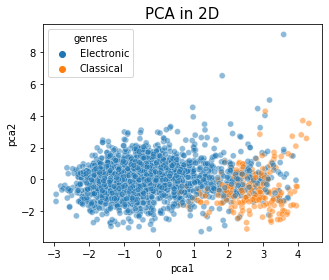

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(df.iloc[:,:10])
scaled_df = scaler.transform(df.iloc[:,:10])

pca =PCA(2, random_state=42)
pca.fit(scaled_df)
df_pca = pca.transform(scaled_df)

df_graph = pd.DataFrame()
df_graph['pca1'] = df_pca[:,0]
df_graph['pca2'] = df_pca[:,1]
df_graph['genres'] = df['genre_top'].values

# plot scatter of PCA
plt.figure(figsize=(5,4))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    data=df_graph,
    legend="full",
    alpha=0.5
)

plt.title("PCA in 2D", fontsize= 15)
plt.show()

In [ ]:
########################################################################################################

# Data Partitioning

In [56]:
# partitioning trainig set
X = df.iloc[:,:10]
# extracting labels
y = df['genre_top']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.3, random_state=42, stratify=y_dev)

In [57]:
# encoding labels in type bool - RIPPER takes only boolean values as labels
le = preprocessing.LabelEncoder()
y_test_enc = ~le.fit_transform(y_test).astype('bool')
y_train_enc = ~le.fit_transform(y_train).astype('bool')
y_dev_enc = ~le.fit_transform(y_dev).astype('bool')
y_val_enc = ~le.fit_transform(y_val).astype('bool')

In [58]:
#help(lw.RIPPER)

# RIPPER

With pos_class == 'Classical' the scores are low for both classes.
If pos_class == 'Electronic' RIPPER tries to maximize Classical (it can be seen when the pruning is 1, the recall for False which is Classical, is equal to 100%)

### Grid Search

In [60]:
for pr in [0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        clf = lw.RIPPER(random_state=42, prune_size=pr)
        clf.fit(X_train, y_train, pos_class='Classical')
        y_predicted = clf.predict(X_val)
        print("prune_size: ", pr)
        print(classification_report(y_val_enc, y_predicted))

prune_size:  0.1
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       435
        True       0.70      0.85      0.76        46

    accuracy                           0.95       481
   macro avg       0.84      0.90      0.87       481
weighted avg       0.96      0.95      0.95       481

prune_size:  0.15
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       435
        True       0.70      0.85      0.76        46

    accuracy                           0.95       481
   macro avg       0.84      0.90      0.87       481
weighted avg       0.96      0.95      0.95       481

prune_size:  0.2
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       435
        True       0.75      0.78      0.77        46

    accuracy                           0.95       481
   macro avg       0.86      0.88      0.87       481
weighted avg       0.9

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



#### Retrain best model

In [61]:
clf = lw.RIPPER(random_state=42, prune_size=0.1)
clf.fit(X_dev, y_dev, pos_class='Classical')

In [62]:
y_predicted = clf.predict(X_test)
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       622
        True       0.73      0.94      0.82        65

    accuracy                           0.96       687
   macro avg       0.86      0.95      0.90       687
weighted avg       0.97      0.96      0.96       687



#### Extract Rules

In [27]:
clf.out_model()

[[acousticness=0.99-1.0 ^ energy=0.0-0.09] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ tempo=12.75-82.95] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ valence=0.05-0.11] V
[energy=0.0-0.09 ^ acousticness=0.89-0.99 ^ instrumentalness=0.0-0.33] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ tempo=90.38-100.0] V
[acousticness=0.99-1.0 ^ valence=0.18-0.28] V
[acousticness=0.89-0.99 ^ energy=0.0-0.09 ^ liveness=0.11-0.12] V
[energy=0.09-0.29 ^ bit_rate=-1-160 ^ duration=302-349] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ bit_rate=-1-160] V
[energy=0.0-0.09 ^ liveness=0.33-0.94] V
[acousticness=0.99-1.0 ^ danceability=0.37-0.45] V
[acousticness=0.89-0.99 ^ valence=0.28-0.38 ^ danceability=0.26-0.37] V
[valence=0.11-0.18 ^ danceability=0.06-0.26 ^ speechiness=0.02-0.04] V
[energy=0.09-0.29 ^ instrumentalness=0.0-0.33 ^ danceability=0.06-0.26] V
[acousticness=0.99-1.0 ^ valence=0.58-0.71]]


#### Plot ROC curve

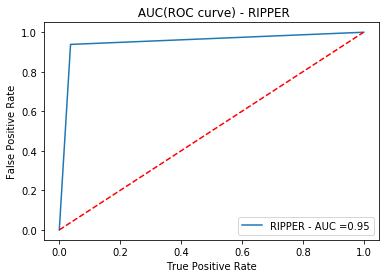

In [63]:
plot_roc_curve(y_test_enc, y_predicted, 'RIPPER')

#### Plot Confusion Matrix

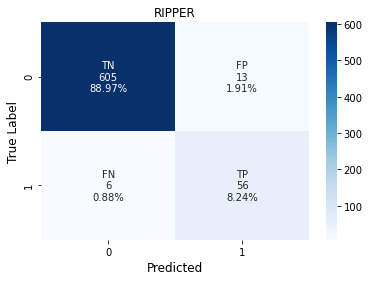

In [29]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'RIPPER')

#### Retrain the model

In [29]:
irep_clf = lw.IREP(random_state=42, prune_size=0.55)
irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Classical')

In [30]:
y_predicted = irep_clf.predict(X_test)

In [31]:
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       622
        True       0.77      0.89      0.83        65

    accuracy                           0.97       687
   macro avg       0.88      0.93      0.90       687
weighted avg       0.97      0.97      0.97       687



In [32]:
irep_clf.out_model()

[[acousticness=0.99-1.0] V
[acousticness=0.9-0.99 ^ energy=0.0-0.08 ^ tempo=26.13-82.65]]


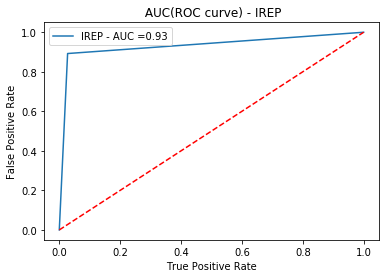

In [33]:
plot_roc_curve(y_test_enc, y_predicted, 'IREP')

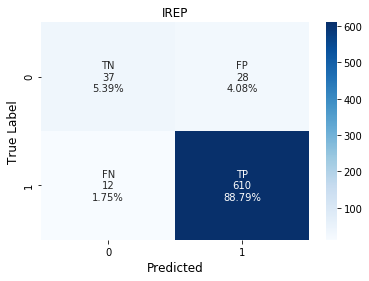

In [274]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'IREP')